In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf

FLAGS = None

In [2]:
rng = np.random.RandomState()
crop = 1
ds_factor = 2.
eig_frac_cutoff = .0001
lr = .5

def new_shape(crop, ds_factor):
    return int(np.around((28 - crop) / ds_factor))

def transform(X, crop=2, ds_factor=2.):
    Xp = tf.reshape(X, (-1, 28, 28))
    Xp = Xp[:, crop:28-crop, crop:28-crop]
    new = new_shape(crop, ds_factor)
    Xp = tf.image.resize_images(tf.expand_dims(Xp, axis=-1), (new, new))
    return tf.reshape(Xp, (-1, new**2))

In [3]:
mnist = input_data.read_data_sets('/tmp/tensorflow/mnist/input_data/', one_hot=True)
new_dim = new_shape(crop, ds_factor) **2
# Create the model
x = tf.placeholder(tf.float32, [None, 784])
x_small = transform(x, crop, ds_factor)
p = tf.Variable(tf.zeros((new_dim * 10) + 10))
W = tf.reshape(p[:new_dim * 10], [new_dim, 10])
b = tf.reshape(p[new_dim * 10:], [10])

y = tf.matmul(x_small, W) + b

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz


In [4]:
opt = tf.train.GradientDescentOptimizer(learning_rate=lr)
grad, var = opt.compute_gradients(cross_entropy, var_list=[p])[0]
grad2 = tf.reshape(grad, (grad.shape[0], 1))

# Meaningless outside pixel make Hessian not invertable, cropping would fix need for tf.eye
hess = tf.squeeze(tf.hessians(cross_entropy, p)) #+ .0001 * tf.eye((new_dim * 10) + 10)
e, v = tf.self_adjoint_eig(tf.expand_dims(hess, axis=0))
thresh = tf.reduce_sum(e) * eig_frac_cutoff
keep = tf.reduce_sum(tf.cast(tf.greater_equal(e, thresh), tf.int32))
ep = tf.squeeze(e)[-keep:]
vp = tf.squeeze(v)[:, -keep:]
inv_hess = tf.matmul(vp, (1. / tf.expand_dims(ep, axis=0)) * vp, transpose_b=True)
grad_prime = tf.squeeze(tf.matmul(inv_hess, grad2))
train_step = opt.apply_gradients([(grad_prime, var)])

In [5]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

training
0.098
0.1005
[ 0.10018998  0.10018999  0.12420424  0.12420426  0.12420427  0.12420427
  0.12420429  0.12420429  0.1242043   0.12420431  0.12420446  1.20389736
  1.2038976   1.2038976   1.2038976   1.20389771  1.20389771  1.20389783
  1.20389783  1.20389783] 657
0.9042
0.896
[ 0.02046129  0.02132325  0.02179124  0.02344738  0.02461751  0.02577905
  0.02627416  0.02741581  0.03645097  0.03774919  0.04556952  0.10490498
  0.1259781   0.15657344  0.18695572  0.18923613  0.25808707  0.34798396
  0.35845736  0.44262925] 523
0.8974
0.893
[ 0.02101834  0.02123034  0.02229899  0.02252946  0.02404525  0.0259186
  0.02685346  0.02856009  0.03214049  0.04147491  0.0443987   0.09778918
  0.1100804   0.13144001  0.1633074   0.18491238  0.24991818  0.33292389
  0.37986669  0.42701444] 517
0.8945
0.8885
[ 0.020045    0.02088316  0.021769    0.02349718  0.02409672  0.02814592
  0.02929687  0.03063358  0.03453105  0.04085855  0.04378879  0.08969641
  0.09842668  0.12850182  0.17094636  0.194007

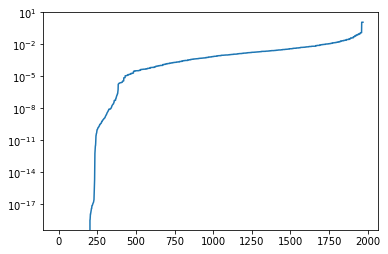

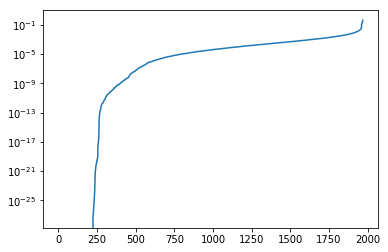

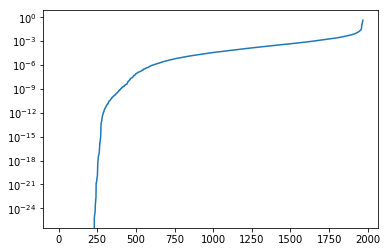

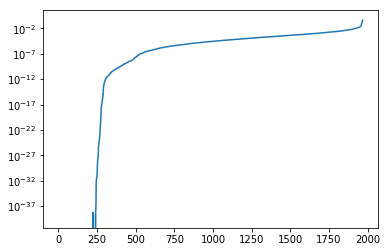

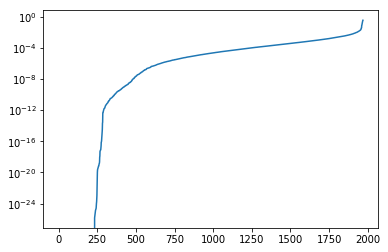

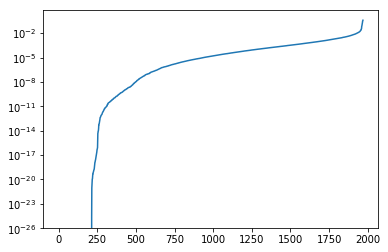

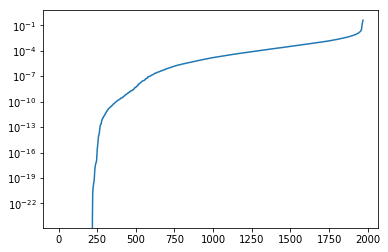

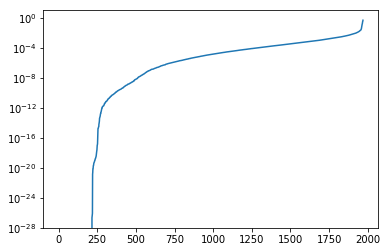

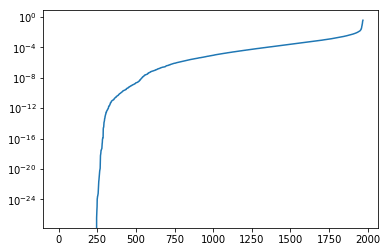

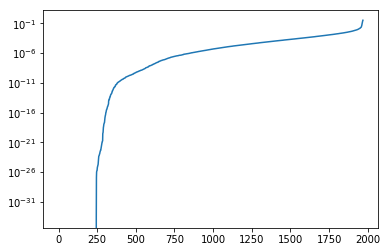

In [6]:
plt.close()
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Train
print('training')
for ii in range(100):
    batch_xs, batch_ys = mnist.train.next_batch(2000)
    if ii % 10 == 0:
        print(sess.run(accuracy, feed_dict={x: mnist.test.images,
                                  y_: mnist.test.labels}))
        print(sess.run(accuracy, feed_dict={x: batch_xs, y_: batch_ys}))
        plt.figure()
        n, e_float = sess.run([keep, e], feed_dict={x: batch_xs, y_: batch_ys})
        e_float = e_float.ravel()
        e_float[e_float < 0] = 0.
        plt.semilogy(e_float.ravel())
        print(e_float.ravel()[-20:], n)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

print('test')
print(sess.run(accuracy, feed_dict={x: mnist.test.images,
                                  y_: mnist.test.labels}))
plt.show()